# Surface Flux Taylor Series
This notebook uses output from Isca to perform taylor series decompostion on both latent and sensible heat fluxes.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile, sphum_sat
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat, annual_mean
from isca_tools.utils.constants import c_p, R, R_v, kappa, L_v
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize

2023-10-02 09:30:01,756 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [87]:
# Load dataset
var_keep = ['flux_t', 'flux_lhe', 'temp', 'ps', 'sphum', 't_surf', 'w_atm', 'drag_q', 'drag_t', 'rho', 'q_atm', 'q_surf', 't_atm', 'p_atm', 
            'lwdn_sfc', 'lwup_sfc', 'swdn_sfc']
exp_names = ['aquaplanet/no_wishe/k=1', 'aquaplanet/no_wishe/normal_wind']
n_exp = len(exp_names)
use_time_start = 360*2
# only load in atmos level closest to surface, for times after spin up
ds_base = [isca_tools.load_dataset(exp_names[i]).sel(pfull=np.inf, method='nearest')[var_keep] for i in range(n_exp)] 
for i in range(n_exp):
    ds_base[i] = ds_base[i].sel(time=slice(use_time_start, np.inf))
# namelist = isca_tools.load_namelist(exp_names[0])  # Need this for albedo_value
w_atm_const = [isca_tools.load_namelist(exp_names[i])['surface_flux_nml']['w_atm_const'] for i in range(n_exp)]

In [120]:
# Consider a single latitude
loc = {'lat':70}
ds_sl = [ds_base[i].sel(lat=loc['lat'], method='nearest').load() for i in range(n_exp)]
ds_sl_av = [annual_mean(ds_base[i].sel(lat=loc['lat'], method='nearest')).mean(dim='lon').load() for i in range(n_exp)]
n_year_days = 360
time_array = np.arange(n_year_days)

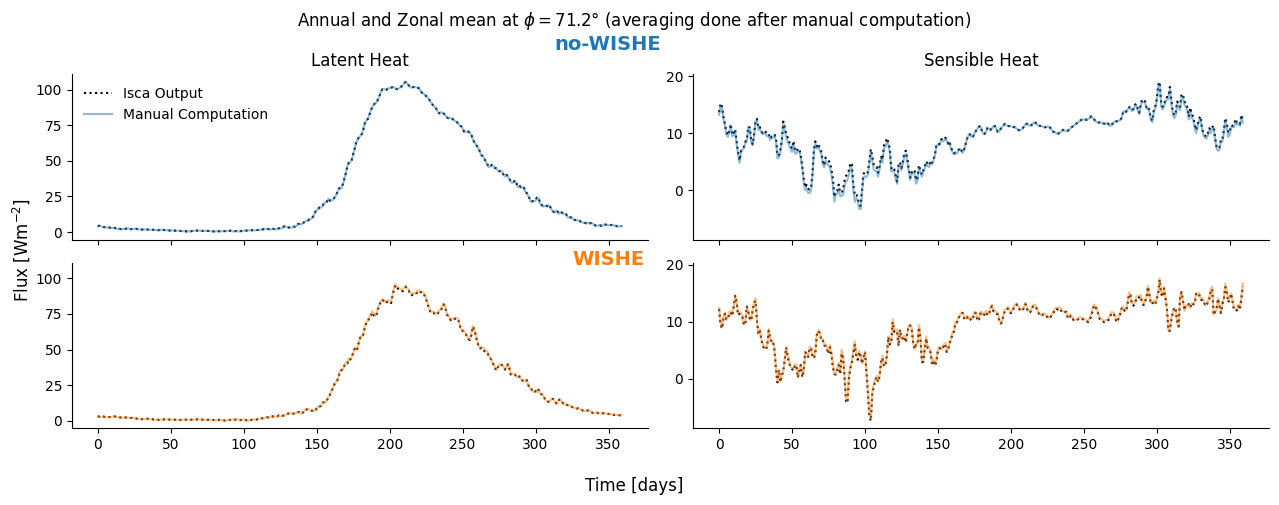

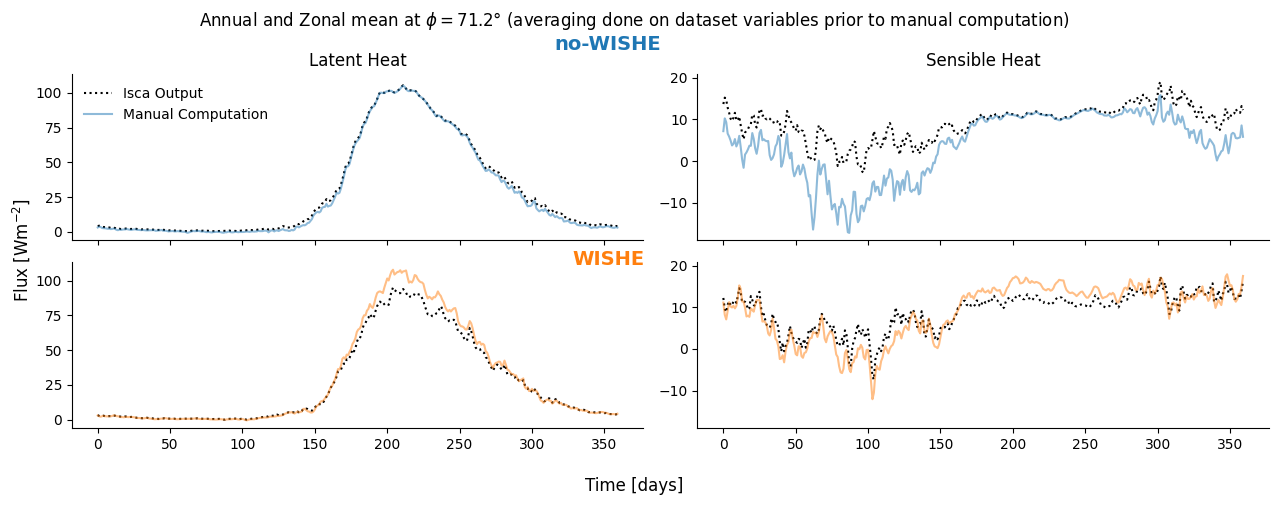

In [151]:
exp_labels = ['no-WISHE', 'WISHE']
# for ds_all in [ds_sl, ds_sl_av, [annual_mean(ds_sl[j]) for j in range(n_exp)], [ds_sl[j].mean(dim='lon') for j in range(n_exp)]]:
for ds_all in [ds_sl, ds_sl_av]:
    w_atm_use = [w_atm_const[i] if w_atm_const[i]>0 else ds_all[i].w_atm for i in range(n_exp)]
    flux_lh_manual = [ds_use.drag_q * w_atm_use[i] * ds_use.rho * (ds_use.q_surf - ds_use.q_atm) * L_v for i, ds_use in enumerate(ds_all)]
    flux_sh_manual = [ds_use.drag_t * w_atm_use[i] * ds_use.rho * (ds_use.t_surf - ds_use.t_atm * (ds_use.ps/ds_use.p_atm)**kappa) * c_p for 
                      i, ds_use in enumerate(ds_all)]
    
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(n_exp,2, figsize=(13, 5), sharex=True, sharey='col')
    take_annual_mean = ds_all[0].time[-1]>n_year_days
    take_zonal_mean = 'lon' in ds_all[0]
    if take_zonal_mean and take_annual_mean:
        av_func = lambda x: annual_mean(x).mean(dim='lon')
        av_title = 'averaging done after manual computation'
    elif take_annual_mean:
        av_func = lambda x: annual_mean(x)
        av_title = 'zonal averaging done on dataset variables prior to manual computation' 
    elif take_zonal_mean:
        av_func = lambda x: x.mean(dim='lon')
        av_title = 'temporal averaging done on dataset variables prior to manual computation' 
    else:
        av_func = lambda x: x
        av_title = 'averaging done on dataset variables prior to manual computation' 
    for i, ds_use in enumerate(ds_all):
        ax[i, 0].spines[['top', 'right']].set_visible(False)
        ax[i, 1].spines[['top', 'right']].set_visible(False)
        ax[i, 0].plot(time_array, av_func(ds_use.flux_lhe), color='k', linestyle=':', label='Isca Output')
        ax[i, 0].plot(time_array, av_func(flux_lh_manual[i]), alpha=0.5, color=default_colors[i], label='Manual Computation')
        
        ax[i, 1].plot(time_array, av_func(ds_use.flux_t), color='k', linestyle=':')
        ax[i, 1].plot(time_array, av_func(flux_sh_manual[i]), alpha=0.5, color=default_colors[i])
        # ax[i, 1].plot(time_array, flux_sh_manual2[i], alpha=0.5)
        
        # ax[1].plot(ds.time, ds.flux_t, color='k', linestyle=':')
        # ax[1].plot(ds.time, flux_sh_manual, alpha=0.5)
        # ax[1].plot(ds.time, flux_sh_manual2, alpha=0.5)
    ax[0, 0].legend(frameon=False)
    ax[0, 0].set_title('Latent Heat')
    ax[0, 1].set_title('Sensible Heat')
    plt.figtext(0.48,0.93, "no-WISHE", ha="center", va="top", fontsize=14, color=default_colors[0], fontweight='bold')
    plt.figtext(0.48,0.5, "WISHE", ha="center", va="top", fontsize=14, color=default_colors[1], fontweight='bold')
    fig.supxlabel('Time [days]')
    fig.supylabel('Flux [Wm$^{-2}$]')
    fig.suptitle(f"Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$ ({av_title})")
    # ax[0].set_ylabel('Flux [W/m$^2$]')
    # fig.supxlabel('Time [days]')
    # fig.suptitle(f"Lat = {loc_use['lat']}$\degree$; Lon = {loc_use['lon']}$\degree$")
    plt.tight_layout()

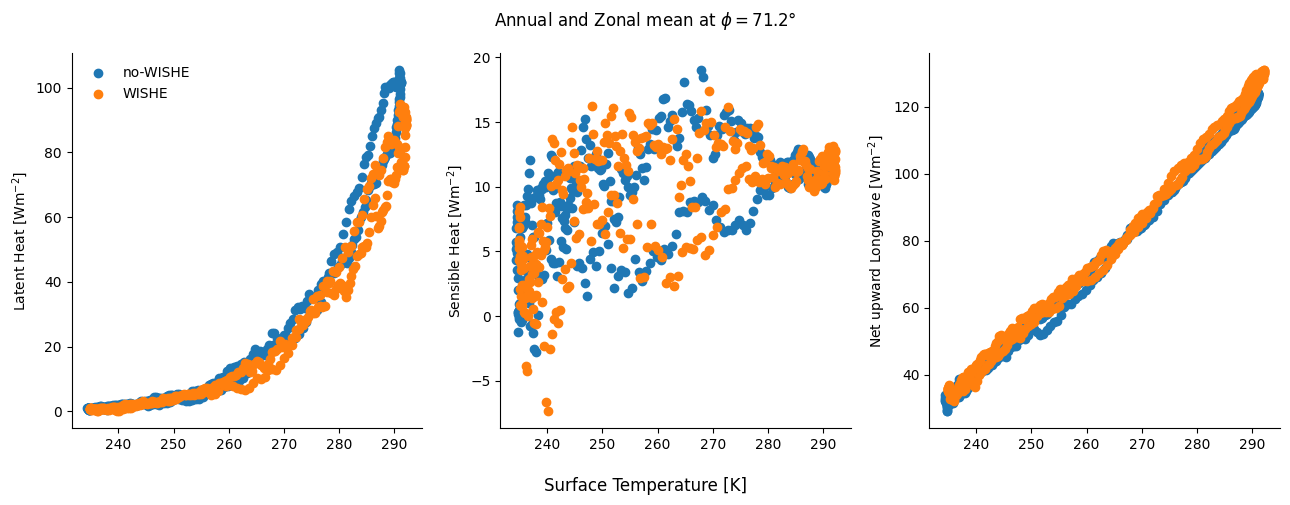

In [122]:
fig, ax = plt.subplots(1,3, figsize=(13, 5), sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[2].spines[['top', 'right']].set_visible(False)
for i in range(n_exp):
    ax[0].scatter(ds_sl_av[i].t_surf, ds_sl_av[i].flux_lhe, color=default_colors[i], label=exp_labels[i])
    ax[1].scatter(ds_sl_av[i].t_surf, ds_sl_av[i].flux_t, color=default_colors[i])
    ax[2].scatter(ds_sl_av[i].t_surf, ds_sl_av[i].lwup_sfc - ds_sl_av[i].lwdn_sfc, color=default_colors[i])
ax[0].legend(frameon=False)
ax[0].set_ylabel('Latent Heat [Wm$^{-2}$]')
ax[1].set_ylabel('Sensible Heat [Wm$^{-2}$]')
ax[2].set_ylabel('Net upward Longwave [Wm$^{-2}$]')
fig.supxlabel('Surface Temperature [K]')
fig.suptitle(f'Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$')
plt.tight_layout();